## Fungi classification data pre-processing
Below are the steps to import the source data for pre-processing before modelling in MATLAB.

In [156]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import string

In [157]:
import pickle
# Function to serialise object
def save_pickle(file_nm, obj):
    pickle_out = open(file_nm, 'wb')
    pickle.dump(obj, pickle_out)
    pickle_out.close()

# Function to load object from pickle file
def load_pickle(file_nm):
    pickle_in = open(file_nm, 'rb')
    obj = pickle.load(pickle_in)
    return obj

### Read in the source file and wrangle into a data frame

In [158]:
# Read the source file (text file)
src_data_txt_ls = []
src_file_path = 'src_data'
with open(src_file_path) as fp:
    for i, line in enumerate(fp):
        # Read from line 10 after header
        if i >= 10:
            src_data_txt_ls += [line]

# Split each value by delimiter ','
src_data_txt_ls = [line.split(',') for line in src_data_txt_ls]
# Strip end of line break \n
src_data_txt_ls = [[val.replace('\n', '') for val in line] for line in src_data_txt_ls]
# Convert into data frame
src_df = pd.DataFrame(src_data_txt_ls)
# Assign variable names per source data documentation
# https://archive.ics.uci.edu/ml/datasets/mushroom

# Define a dictionary to capture variable names and classes
# Each class is mapped to a level value
variables_def_dct = {
'edible': {'edible':1, 'poisonous':-1},
'cap_shape': {'bell':1, 'conical':2, 'convex':3, 'flat':4,  'knobbed':5, 'sunken':6},
'cap_surface': {'fibrous':1, 'grooves':2, 'scaly':3, 'smooth':4},
'cap_color': {'brown':1, 'buff':2, 'cinnamon':3, 'gray':4, 'green':5, 'pink':6, 'purple':7, 'red':8, 'white':9, 'yellow':10},
'bruises': {'bruises':1, 'no':2},
'odor': {'almond':1, 'anise':2, 'creosote':3, 'fishy':4, 'foul':5,  'musty':6, 'none':7, 'pungent':8, 'spicy':9},
'gill_attachment': {'attached':1, 'descending':2, 'free':3, 'notched':4},
'gill_spacing': {'close':1, 'crowded':2, 'distant':3},
'gill_size': {'broad':1, 'narrow':2},
'gill_color': {'black':1, 'brown':2, 'buff':3, 'chocolate':4, 'gray':5,  'green':6, 'orange':7, 'pink':8, 'purple':9, 'red':10, 'white':11, 'yellow':12},
'stalk_shape': {'enlarging':1, 'tapering':2},
'stalk_root': {'bulbous':1, 'club':2, 'cup':3, 'equal':4,  'rhizomorphs':5, 'rooted':6, 'missing':7},
'stalk_surface_above_ring': {'fibrous':1, 'scaly':2, 'silky':3, 'smooth':4},
'stalk_surface_below_ring': {'fibrous':1, 'scaly':2, 'silky':3, 'smooth':4},
'stalk_color_above_ring': {'brown':1, 'buff':2, 'cinnamon':3, 'gray':4, 'orange':5,  'pink':6, 'red':7, 'white':8, 'yellow':9},
'stalk_color_below_ring': {'brown':1, 'buff':2, 'cinnamon':3, 'gray':4, 'orange':5,  'pink':6, 'red':7, 'white':8, 'yellow':9},
'veil_type': {'partial':1, 'universal':2},
'veil_color': {'brown':1, 'orange':2, 'white':3, 'yellow':4},
'ring_number': {'none':1, 'one':2, 'two':3},
'ring_type': {'cobwebby':1, 'evanescent':2, 'flaring':3, 'large':4,  'none':5, 'pendant':6, 'sheathing':7, 'zone':8},
'spore_print_color': {'black':1, 'brown':2, 'buff':3, 'chocolate':4, 'green':5,  'orange':6, 'purple':7, 'white':8, 'yellow':9},
'population': {'abundant':1, 'clustered':2, 'numerous':3, 'scattered':4, 'several':5, 'solitary':6},
'habitat': {'grasses':1, 'leaves':2, 'meadows':3, 'paths':4, 'urban':5, 'waste':6, 'woods':7},
}

# Set data frame variables to align with definition
src_df.columns = list(variables_def_dct.keys())
src_df.head()

,edible,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,WHITE,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
1,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,PINK,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
2,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,PINK,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
3,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,BROWN,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
4,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,BROWN,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS


In [159]:
# Map values in variables to the class levels
def map_levels(df_ls, def_dct):
    # Lower the original value then map to the class level value
    # Where value is None (i.e. missing) is set to 0
    new_ls = [val.lower() if val is not None else np.NaN for val in list(df_ls)]
    new_ls = [def_dct.get(val) if val != np.NaN else np.NaN for val in new_ls]
    return new_ls

# For each column, map to corresponding class levels
for col in list(src_df.columns):
    # Get mapping for specific variable
    var_dct = variables_def_dct.get(col)
    # Map each value to class level
    src_df[col] = map_levels(list(src_df[col]), var_dct)

# Fill na
src_df.fillna(0, inplace=True)
    
src_df.head()

,edible,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,1.0,3.0,4.0,9.0,1.0,1.0,3.0,2.0,2.0,11.0,...,4.0,8.0,8.0,1.0,3.0,2.0,6.0,2.0,5.0,7.0
1,1.0,3.0,4.0,9.0,1.0,1.0,3.0,2.0,2.0,8.0,...,4.0,8.0,8.0,1.0,3.0,2.0,6.0,7.0,5.0,7.0
2,1.0,3.0,4.0,9.0,1.0,1.0,3.0,2.0,2.0,8.0,...,4.0,8.0,8.0,1.0,3.0,2.0,6.0,2.0,5.0,7.0
3,1.0,3.0,4.0,9.0,1.0,1.0,3.0,2.0,2.0,2.0,...,4.0,8.0,8.0,1.0,3.0,2.0,6.0,7.0,5.0,7.0
4,1.0,3.0,4.0,9.0,1.0,1.0,3.0,2.0,2.0,2.0,...,4.0,8.0,8.0,1.0,3.0,2.0,6.0,2.0,5.0,7.0


In [160]:
src_df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
edible,8416.0,0.066421,0.997791,-1.0,-1.0,1.0,1.0,1.0
cap_shape,8416.0,3.493940,0.892811,0.0,3.0,3.0,4.0,6.0
cap_surface,8416.0,2.733365,1.191058,0.0,1.0,3.0,4.0,4.0
cap_color,8416.0,5.263664,3.403468,0.0,1.0,4.0,9.0,10.0
bruises,8416.0,1.598740,0.490425,0.0,1.0,2.0,2.0,2.0
odor,8416.0,5.828779,1.961370,0.0,5.0,7.0,7.0,9.0
gill_attachment,8416.0,2.948313,0.317917,0.0,3.0,3.0,3.0,3.0
gill_spacing,8416.0,1.188926,0.391776,0.0,1.0,1.0,1.0,2.0
gill_size,8416.0,1.301093,0.459019,0.0,1.0,1.0,2.0,2.0
gill_color,8416.0,5.691183,3.353812,0.0,3.0,5.0,8.0,12.0


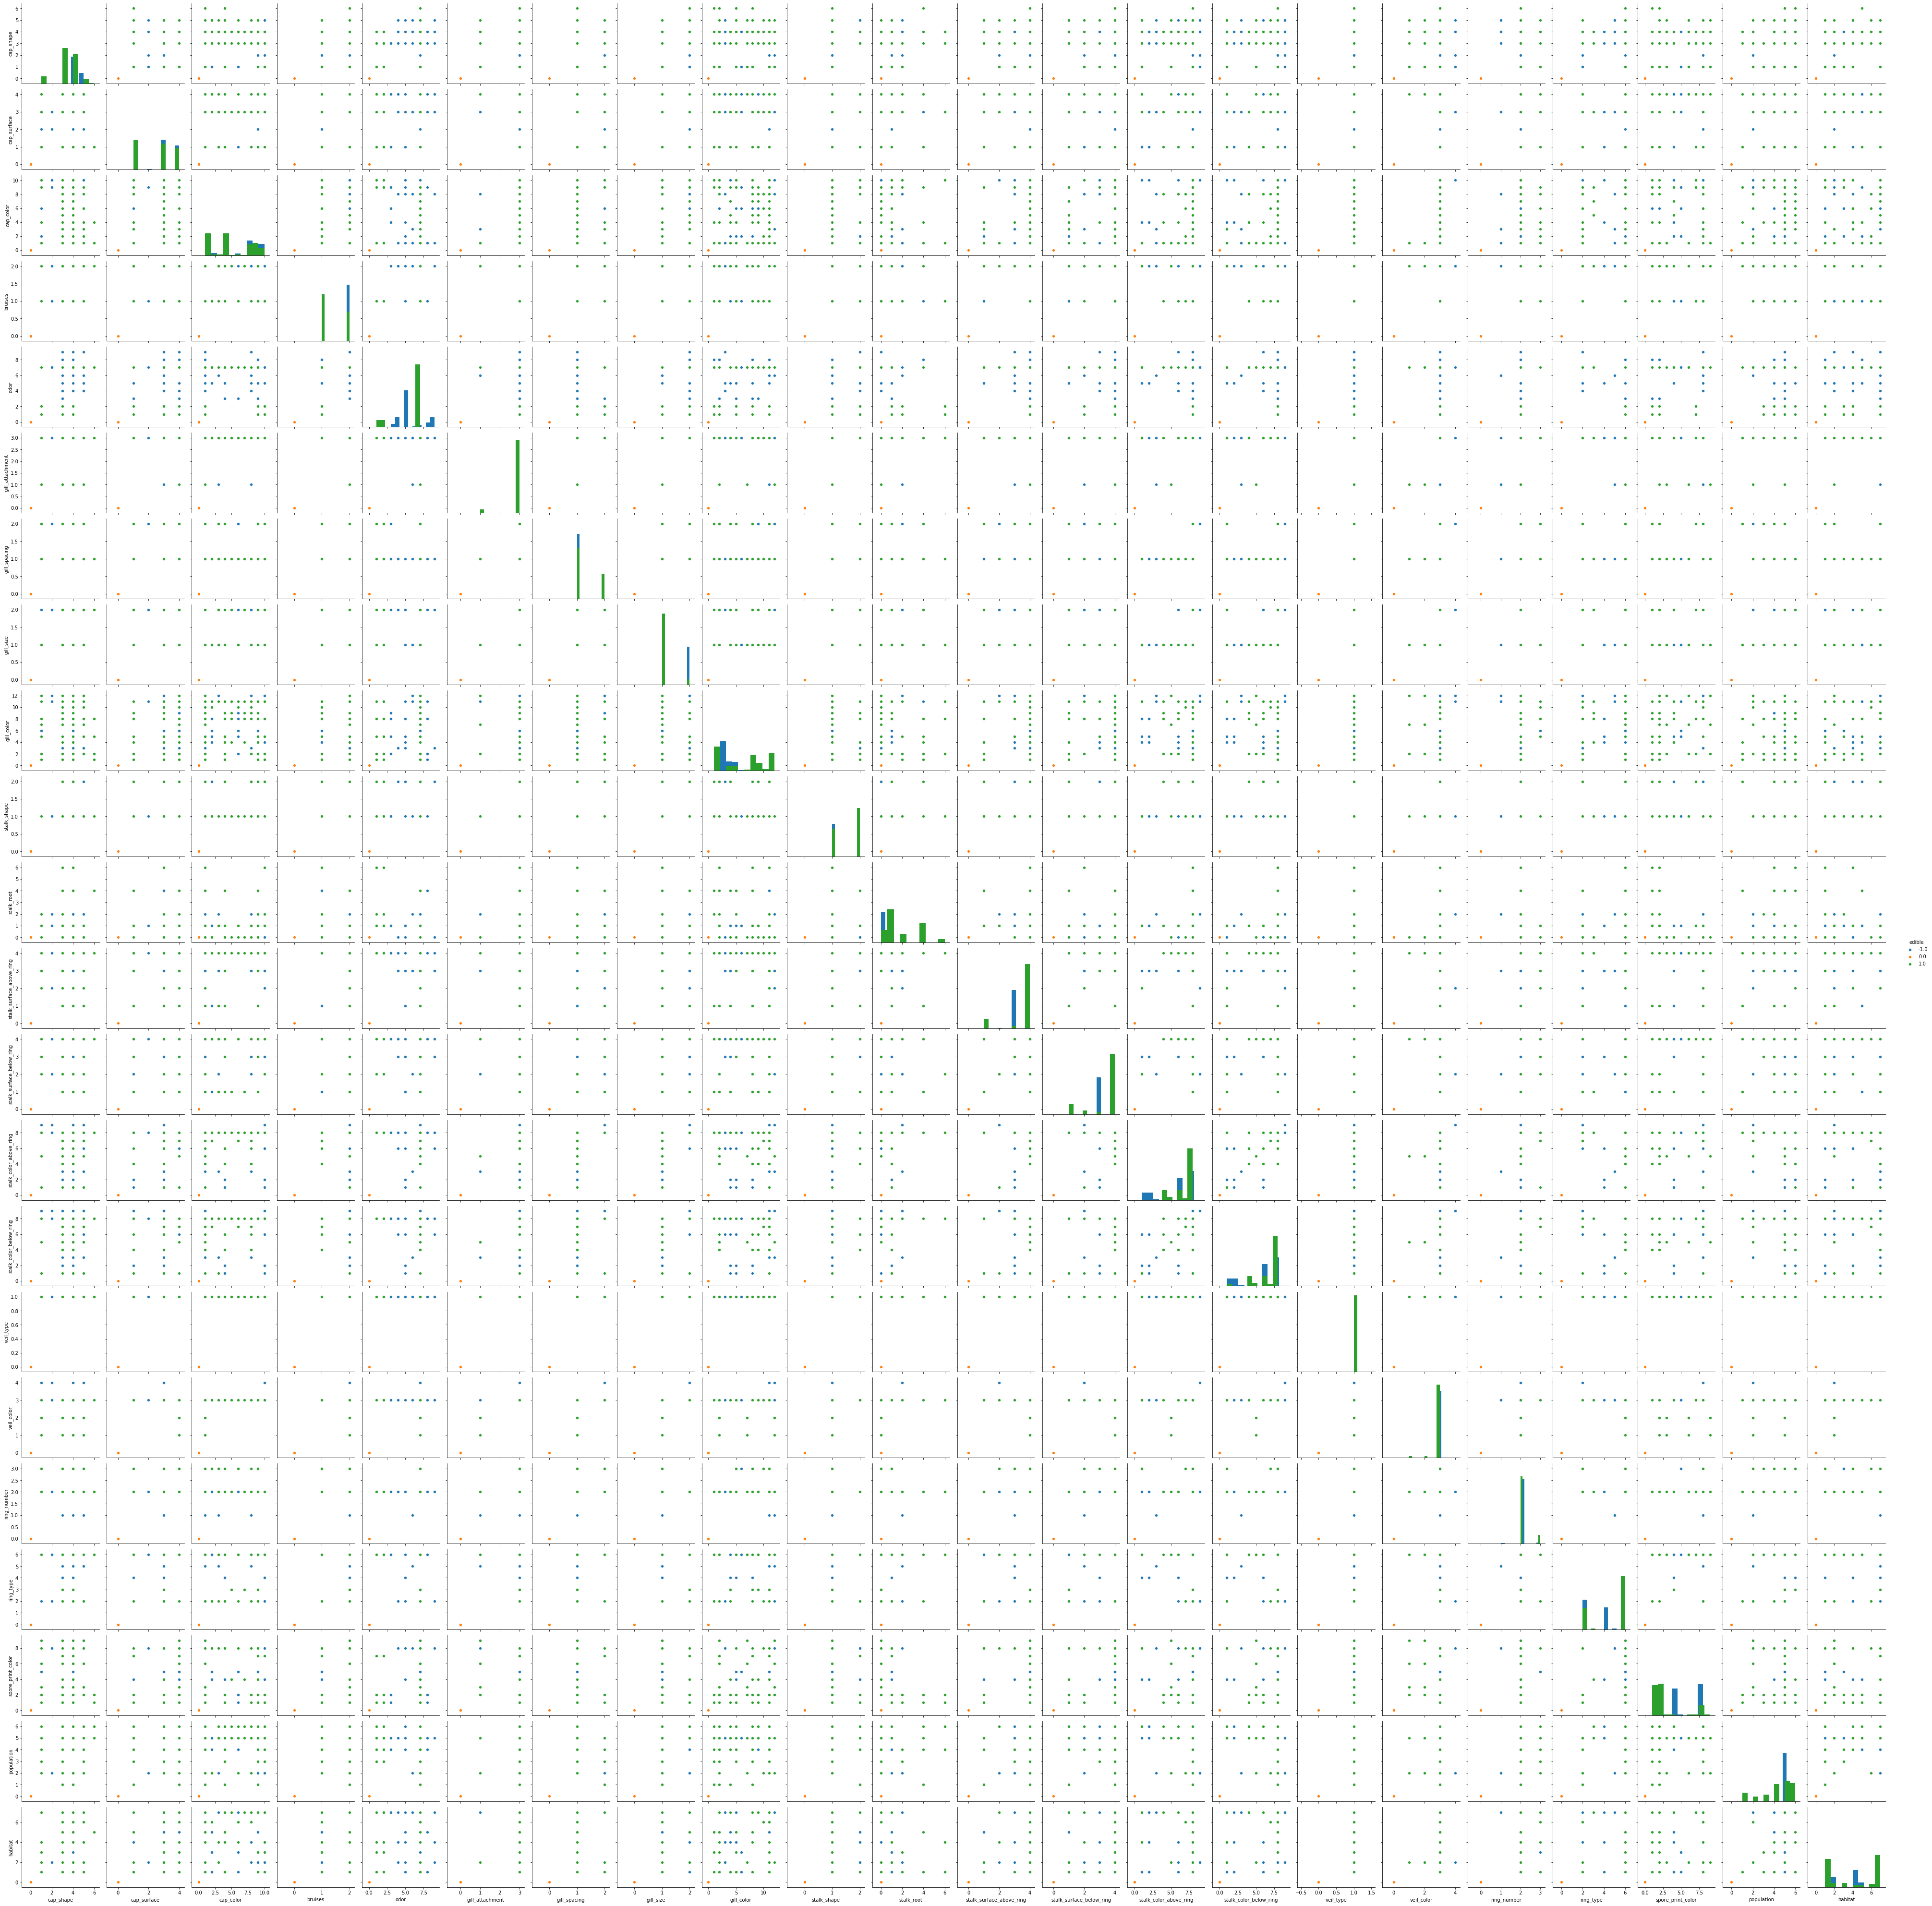

In [167]:
# Pair plot to identify any correlations between two given variables
g = sns.pairplot(src_df, diag_kind='hist', corner=False, hue='edible')
g.savefig('pair_plot.png')

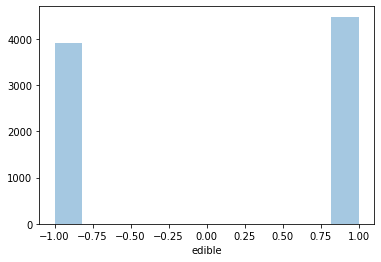

In [161]:
# Histogram for the target variable (closed_taken)
sns.distplot(src_df['edible'], kde=False);

It would appear that the target variable 'edible' is relatively balanced.

In [162]:
# Export file to Excel
src_df.to_excel('src_df.xlsx', index=False)